#### Finding an optimal template for finetuning

In [22]:
import numpy as np
import json
from PIL import Image
from tqdm import tqdm

import sys
sys.path.append('..')

import argparse
import torch

from llava.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN
from llava.conversation import conv_templates, SeparatorStyle
from llava.model.builder import load_pretrained_model
from llava.utils import disable_torch_init
from llava.mm_utils import process_images, tokenizer_image_token, get_model_name_from_path

from PIL import Image

import requests
from PIL import Image
from io import BytesIO
from transformers import TextStreamer

In [8]:
MODEL_NAME = "liuhaotian/llava-v1.6-34b"
temperature = 0.2
max_new_tokens = 512
num_models = 2
models = []

disable_torch_init()

model_name = get_model_name_from_path(MODEL_NAME)
tokenizer, model, image_processor, context_len = load_pretrained_model(MODEL_NAME, model_base=None, model_name=model_name, load_8bit=False, load_4bit=False, device_map="auto")

You are using a model of type llava to instantiate a model of type llava_llama. This is not supported for all configurations of models and can yield errors.
/homes/55/kumud/anaconda/envs/experiments/lib/python3.12/site-packages/torch/nn/modules/module.py:2047: UserWarning: for vision_model.embeddings.class_embedding: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(f'for {key}: copying from a non-meta parameter in the checkpoint to a meta '
/homes/55/kumud/anaconda/envs/experiments/lib/python3.12/site-packages/torch/nn/modules/module.py:2047: UserWarning: for vision_model.embeddings.patch_embedding.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assi

Loading checkpoint shards:   0%|          | 0/15 [00:00<?, ?it/s]

In [9]:
with open("../dataset/train.json", "r") as f:
    pairs = json.load(f)

In [10]:
pairs[0]

{'data_point_1': {'id': 620701,
  'image_id': 620701,
  'similarity_score': 1,
  'source_dataset': 2,
  'falsified': False},
 'data_point_2': {'id': 1179991,
  'image_id': 1179991,
  'similarity_score': 1,
  'falsified': False},
 'search_dir': '../../news_clippings/news_clippings/data/semantics_clip_text_image/train.json'}

In [23]:
def get_data_elements(ann):
    visual_news_data = json.load(open("../../datasets/visualnews/origin/data.json"))
    visual_news_data_mapping = {ann["id"]: ann for ann in visual_news_data}


    caption = visual_news_data_mapping[ann["id"]]["caption"]
    image_path = visual_news_data_mapping[ann["image_id"]]["image_path"]
    image_path = "../../datasets/visualnews/origin/"+image_path[2:]
    image = Image.open(image_path)
    return image, caption

In [24]:
def find_true(search_dirs, id_to_find):
    for search_dir in search_dirs:
        temp_data = json.load(open(search_dir))
        annotations = temp_data["annotations"]
        #search for true
        for ann in annotations:
            #if id_to_find == ann['id'] and ann['falsified'] == True:
            if id_to_find == ann['id'] and ann['falsified'] == False:
                return search_dir, ann

    return ";-;", ":("

In [25]:
search_dirs = ["../../news_clippings/news_clippings/data/merged_balanced/train.json", 
 "../../news_clippings/news_clippings/data/person_sbert_text_text/train.json",
 "../../news_clippings/news_clippings/data/scene_resnet_place/train.json",
 "../../news_clippings/news_clippings/data/semantics_clip_text_image/train.json",
 "../../news_clippings/news_clippings/data/semantics_clip_text_text/train.json"]

In [26]:
a, b = find_true(search_dirs, 1670772)

In [27]:
a

';-;'

In [14]:

img1, cap1 = get_data_elements(pairs[0]['data_point_1'])
img2, cap2 = get_data_elements(pairs[0]['data_point_2'])
    

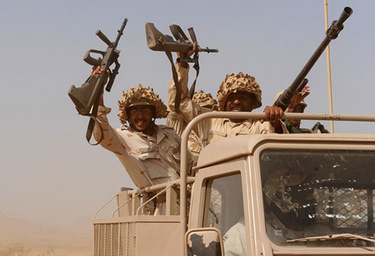

True caption:  Saudi troops cheer as they ride at the back of an army truck in the southwestern province of Jizan near the border with Yemen
Related but False caption:  Israeli soldiers ride on a tank to a position near the Israel Gaza border


In [15]:
if "llama-2" in model_name.lower():
    conv_mode = "llava_llama_2"
elif "mistral" in model_name.lower():
    conv_mode = "mistral_instruct"
elif "v1.6-34b" in model_name.lower():
    conv_mode = "chatml_direct"
elif "v1" in model_name.lower():
    conv_mode = "llava_v1"
elif "mpt" in model_name.lower():
    conv_mode = "mpt"
else:
    conv_mode = "llava_v0"

conv = conv_templates[conv_mode].copy()
if "mpt" in model_name.lower():
    roles = ('user', 'assistant')
else:
    roles = conv.roles

image = img1
image_size = image.size
#show data
display(image)
print("True caption: ", cap1)
print("Related but False caption: ", cap2)

# Similar operation in model_worker.py
image_tensor = process_images([image], image_processor, model.config)
if type(image_tensor) is list:
    image_tensor = [image.to(model.device, dtype=torch.float16) for image in image_tensor]
else:
    image_tensor = image_tensor.to(model.device, dtype=torch.float16)

In [16]:
def task_prompt(role, true_caption, false_caption):
    #define prompt to generate template based output similar to sniffer
    prompt = """ {}: You are given two captions for the given image. One caption is True and the other is False.
                Based on the image, your task is to identify the most obvious element of inconsistency (MUST BE ONE WORD) such as location, time, event, person, organisation etc. in the two captions.
                TRUE CAPTION: {}
                FALSE CAPTION: {}

                You must respond by filling the following template as accurately as possible. 
                Be as concise as possble.
                <template>
                The two captions are inconsistent in: <element>. 
                The <element> in the false caption is: <false_entity>.
                However, the <element> which the true caption and image correspond to is: <true_entity>
                </template>
            """.format(role, true_caption, false_caption)
    return prompt 

In [17]:
#define the task prompt to generate template based response - for finetuning
inp = task_prompt(roles[0], cap1, cap2)

if image is not None:
    # first message
    if model.config.mm_use_im_start_end:
        inp = DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN + DEFAULT_IM_END_TOKEN + '\n' + inp
    else:
        inp = DEFAULT_IMAGE_TOKEN + '\n' + inp
    image = None

conv.append_message(conv.roles[0], inp)
conv.append_message(conv.roles[1], None)
prompt = conv.get_prompt()

input_ids = tokenizer_image_token(prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors='pt').unsqueeze(0).to(model.device)
stop_str = conv.sep if conv.sep_style != SeparatorStyle.TWO else conv.sep2
keywords = [stop_str]
streamer = TextStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)

with torch.inference_mode():
    output_ids = model.generate(
        input_ids,
        images=image_tensor,
        image_sizes=[image_size],
        do_sample=True if temperature > 0 else False,
        temperature=temperature,
        max_new_tokens=max_new_tokens,
        streamer=streamer,
        use_cache=True)

outputs = tokenizer.decode(output_ids[0]).strip()
conv.messages[-1][-1] = outputs

#print("\n", {"prompt": prompt, "outputs": outputs}, "\n")

The two captions are inconsistent in: location.
The location in the false caption is: Israel Gaza border.
However, the location which the true caption and image correspond to is: southwestern province of Jizan near the border with Yemen.


In [19]:
lines = outputs.splitlines()

In [21]:
lines[0]

'The two captions are inconsistent in: location.'